In [428]:
import pandas as pd
import numpy as np
from tabulate import tabulate
import warnings
import statistics
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,mean_squared_error

## This projects goal is to analyze some of the descriptive statistics from public, synthetic medical claims files
#files were obtained from https://www.cms.gov/Research-Statistics-Data-and-Systems/Downloadable-Public-Use-Files/SynPUFs/DE_Syn_PUF

In [429]:
warnings.simplefilter(action = 'ignore')

##Initialize data
# read in data
inpatient = pd.read_csv('/Users//Desktop/inpatient.csv')
outpatient = pd.read_csv('/Users//Desktop/outpatient.csv')
bene = pd.read_csv('/Users//Desktop/Beneficiary.csv')

#get a look into the data size
print('Inpatient claims data size:', inpatient.shape)
print('Outpatient claims data size:',outpatient.shape)
print('Beneficiary claims data size:', bene.shape)

#display tables / get first glances
#outpatient.head(5)
#inpatient.head(5)
#bene.head(5)

Inpatient claims data size: (66773, 81)
Outpatient claims data size: (790790, 76)
Beneficiary claims data size: (116352, 32)


In [430]:
##organize data as needed

#change beneficiary birthday to datetime
bene.BENE_BIRTH_DT =pd.to_datetime(bene.BENE_BIRTH_DT, format='%Y%m%d')

#add age in years as 'AGE_YEAR' to beneficiaries dataframe
now_time = pd.to_datetime('2010-01-01')
diff = now_time - bene.BENE_BIRTH_DT
diff_s = diff.dt.total_seconds()
age = divmod(diff_s, 31536000)

bene['AGE_YEARS'] = age[0]

#join outpatient claims and inpatient claims with beneficiaries data
inpatient = inpatient.join(bene.set_index('DESYNPUF_ID'), on='DESYNPUF_ID')
outpatient = outpatient.join(bene.set_index('DESYNPUF_ID'), on=('DESYNPUF_ID'))


#change inpatient and outpatient start and thru dates to datetime
inpatient[['CLM_THRU_DT', 'CLM_FROM_DT']] = inpatient[['CLM_THRU_DT', 'CLM_FROM_DT']].apply(
pd.to_datetime, format ='%Y%m%d')
outpatient[['CLM_THRU_DT', 'CLM_FROM_DT']] = outpatient[['CLM_THRU_DT', 'CLM_FROM_DT']].apply(
pd.to_datetime, format ='%Y%m%d')

#add year of claim to inpatient and outpatient data
inpatient['CLM_FROM_DT_YEAR'] = pd.DatetimeIndex(inpatient.CLM_FROM_DT).year
outpatient['CLM_FROM_DT_YEAR'] = pd.DatetimeIndex(outpatient.CLM_FROM_DT).year

inpatient['CLM_THRU_DT_YEAR'] = pd.DatetimeIndex(inpatient.CLM_THRU_DT).year
outpatient['CLM_THRU_DT_YEAR'] = pd.DatetimeIndex(outpatient.CLM_THRU_DT).year


#add column of count of number of chronic diseases per beneficiary 
count_disease =bene.iloc[:, 12:22]

for rowIndex, row in count_disease.iterrows():
    for columnIndex, value in row.items():
        if value == 2:
            count_disease.at[rowIndex,columnIndex] = 0

bene['TOTAL_CHRONIC_DISEASES'] = count_disease.sum(axis=1)


#remove rows with missing data in beneficiary birthday
inpatient = inpatient[inpatient.BENE_BIRTH_DT.notnull()]
outpatient = outpatient[outpatient.BENE_BIRTH_DT.notnull()]
inpatient = inpatient.drop_duplicates(subset='CLM_ID')
outpatient = outpatient.drop_duplicates(subset='CLM_ID')

In [431]:
## create additional dataframes for later analysis

#inpatient / outpatient by year
inpatient_2008 = inpatient[
    inpatient.CLM_THRU_DT_YEAR == 2008.0].dropna(
        subset=['DESYNPUF_ID']).drop_duplicates(
            subset=['DESYNPUF_ID'])
inpatient_2009 = inpatient[
    inpatient.CLM_THRU_DT_YEAR == 2009.0].dropna(
        subset=['DESYNPUF_ID']).drop_duplicates(
            subset=['DESYNPUF_ID'])
inpatient_2010 = inpatient[
    inpatient.CLM_THRU_DT_YEAR == 2010.0].dropna(
        subset=['DESYNPUF_ID']).drop_duplicates(
            subset=['DESYNPUF_ID'])

outpatient_2008 = outpatient[
    outpatient.CLM_THRU_DT_YEAR == 2008.0].dropna(
        subset=['DESYNPUF_ID']).drop_duplicates(
            subset=['DESYNPUF_ID'])
outpatient_2009 = outpatient[
    outpatient.CLM_THRU_DT_YEAR == 2009.0].dropna(
        subset=['DESYNPUF_ID']).drop_duplicates(
            subset=['DESYNPUF_ID'])
outpatient_2010 = outpatient[
    outpatient.CLM_THRU_DT_YEAR == 2010.0].dropna(
        subset=['DESYNPUF_ID']).drop_duplicates(
            subset=['DESYNPUF_ID'])

In [432]:
##start analysis

#get distribution of number of claims per beneficiary
dist_claims_table = [['Claim Type', '25%', '50%', '75%', '90%'], 
['Outpatient Claims',
 outpatient.DESYNPUF_ID.value_counts().quantile(0.25), 
 outpatient.DESYNPUF_ID.value_counts().quantile(0.5),
 outpatient.DESYNPUF_ID.value_counts().quantile(0.75),
 outpatient.DESYNPUF_ID.value_counts().quantile(.9)],
 ['Inpatient Claims', 
 inpatient.DESYNPUF_ID.value_counts().quantile(0.25),
 inpatient.DESYNPUF_ID.value_counts().quantile(0.5),
 inpatient.DESYNPUF_ID.value_counts().quantile(0.75),
 inpatient.DESYNPUF_ID.value_counts().quantile(.9)
 ]]

#print results
print('Distribution of Number of Claims Per Beneficiary Over 3 Years')
print(tabulate(dist_claims_table, headers = 'firstrow', tablefmt = 'grid'))

Distribution of Number of Claims Per Beneficiary Over 3 Years
+-------------------+-------+-------+-------+-------+
| Claim Type        |   25% |   50% |   75% |   90% |
+===================+=======+=======+=======+=======+
| Outpatient Claims |     3 |     7 |    13 |    20 |
+-------------------+-------+-------+-------+-------+
| Inpatient Claims  |     1 |     1 |     2 |     3 |
+-------------------+-------+-------+-------+-------+


In [433]:
#get demographics of beneficiaries
sex_race_table = [
['', 'Outpatient', 'Inpatient'],

['Total', 
len(outpatient.DESYNPUF_ID.unique()), 
len(inpatient.DESYNPUF_ID.unique())
],

['Sex', '', ''],

['Male',
 str(
    round(
        len(
            outpatient[outpatient.BENE_SEX_IDENT_CD == 1])
            / 
            len(outpatient),3)
            * 100) + '%',
str(
    round(
        (len(
            inpatient[inpatient.BENE_SEX_IDENT_CD == 1])
            / 
            len(inpatient)), 3)
            * 100) + '%'
],
['Female', 
str(
    round(
        (len(
            outpatient[outpatient.BENE_SEX_IDENT_CD == 2])
            / 
            len(outpatient)) * 100,1)) + '%',
str(
    round(
        (len(
            inpatient[inpatient.BENE_SEX_IDENT_CD == 2])
            / 
            len(inpatient))*100, 1)) + '%'

], 

['Race/Ethnicity', '', ''],

['White', 
str(
    round(
        (len(
            outpatient[outpatient.BENE_RACE_CD == 1])
            / 
            len(outpatient)) * 100,1)) + '%',
str(
    round(
        (len(
            inpatient[inpatient.BENE_RACE_CD == 1])
            / 
            len(inpatient))*100, 1)) + '%'
],

['Black', 
str(
    round(
        (len(
            outpatient[outpatient.BENE_RACE_CD == 2])
            / 
            len(outpatient)) * 100,1)) + '%',
str(
    round(
        (len(
            inpatient[inpatient.BENE_RACE_CD == 2])
            / 
            len(inpatient))*100, 1)) + '%'
],

['Hispanic',
str(
    round(
        (len(
            outpatient[outpatient.BENE_RACE_CD == 3])
            / 
            len(outpatient)) * 100,1)) + '%',
str(
    round(
        (len(
            inpatient[inpatient.BENE_RACE_CD == 3])
            / 
            len(inpatient))*100, 1)) + '%'
],

['Other',
str(
    round(
        (len(
            outpatient[outpatient.BENE_RACE_CD == 5])
            / 
            len(outpatient)) * 100,1)) + '%',
str(
    round(
        (len(
            inpatient[inpatient.BENE_RACE_CD == 5])
            / 
            len(inpatient))*100, 1)) + '%'
]
]


print('Sex and Race of Population')
print(tabulate(sex_race_table,headers = 'firstrow', tablefmt = 'grid'))


Sex and Race of Population
+----------------+--------------+-------------+
|                | Outpatient   | Inpatient   |
+================+==============+=============+
| Total          | 85272        | 37780       |
+----------------+--------------+-------------+
| Sex            |              |             |
+----------------+--------------+-------------+
| Male           | 42.3%        | 43.4%       |
+----------------+--------------+-------------+
| Female         | 57.7%        | 56.6%       |
+----------------+--------------+-------------+
| Race/Ethnicity |              |             |
+----------------+--------------+-------------+
| White          | 84.6%        | 84.4%       |
+----------------+--------------+-------------+
| Black          | 9.9%         | 10.5%       |
+----------------+--------------+-------------+
| Hispanic       | 3.5%         | 3.1%        |
+----------------+--------------+-------------+
| Other          | 2.0%         | 1.9%        |
+------------

In [434]:
#comparison of birth ranges of population of beneficiaries

birth_table = [
['Year of Birth', 'Population of Outpatient Claims','Population of Inpatient Claims'],

['-1924',
str(
    round(
        (len(
            outpatient[outpatient.BENE_BIRTH_DT < '1924-01-01'])
            / 
            len(outpatient)) * 100,1)) + '%',
str(
    round(
        (len(
            inpatient[inpatient.BENE_BIRTH_DT < '1924-01-01'])
            / 
            len(inpatient))*100, 1)) + '%'
],

['1924-1928',
str(
    round(
        (len(
            outpatient[outpatient.BENE_BIRTH_DT.between('1924-01-01', '1928-12-31', inclusive = True)])
            / 
            len(outpatient)) * 100,1)) + '%',
str(
    round(
        (len(
            inpatient[inpatient.BENE_BIRTH_DT.between('1924-01-01', '1928-12-31', inclusive = True)])
            / 
            len(inpatient))*100, 1)) + '%'
],

['1929-1933',
str(
    round(
        (len(
            outpatient[outpatient.BENE_BIRTH_DT.between('1929-01-01', '1933-12-31', inclusive = True)])
            / 
            len(outpatient)) * 100,1)) + '%',
str(
    round(
        (len(
            inpatient[inpatient.BENE_BIRTH_DT.between('1929-01-01', '1933-12-31', inclusive = True)])
            / 
            len(inpatient))*100, 1)) + '%'
],

['1934-1938',
str(
    round(
        (len(
            outpatient[outpatient.BENE_BIRTH_DT.between('1934-01-01', '1938-12-31', inclusive = True)])
            / 
            len(outpatient)) * 100,1)) + '%',
str(
    round(
        (len(
            inpatient[inpatient.BENE_BIRTH_DT.between('1934-01-01', '1938-12-31', inclusive = True)])
            / 
            len(inpatient))*100, 1)) + '%'
],

['1939-1943',
str(
    round(
        (len(
            outpatient[outpatient.BENE_BIRTH_DT.between('1939-01-01', '1943-12-31', inclusive = True)])
            / 
            len(outpatient)) * 100,1)) + '%',
str(
    round(
        (len(
            inpatient[inpatient.BENE_BIRTH_DT.between('1939-01-01', '1943-12-31', inclusive = True)])
            / 
            len(inpatient))*100, 1)) + '%'
],

['1943-',
str(
    round(
        (len(
            outpatient[outpatient.BENE_BIRTH_DT > '1944-01-01'])
            / 
            len(outpatient)) * 100,1)) + '%',
str(
    round(
        (len(
            inpatient[inpatient.BENE_BIRTH_DT > '1944-01-01'])
            / 
            len(inpatient))*100, 1)) + '%'
],

['Mean Age',
round(statistics.mean(outpatient.AGE_YEARS),1),
round(statistics.mean(inpatient.AGE_YEARS),1)
]

]

#print results
print('Year of Birth of Beneficiary Population')
print(tabulate(birth_table, headers = 'firstrow', tablefmt = 'grid' ))

Year of Birth of Beneficiary Population
+-----------------+-----------------------------------+----------------------------------+
| Year of Birth   | Population of Outpatient Claims   | Population of Inpatient Claims   |
+=================+===================================+==================================+
| -1924           | 14.8%                             | 17.4%                            |
+-----------------+-----------------------------------+----------------------------------+
| 1924-1928       | 14.0%                             | 14.9%                            |
+-----------------+-----------------------------------+----------------------------------+
| 1929-1933       | 16.4%                             | 16.4%                            |
+-----------------+-----------------------------------+----------------------------------+
| 1934-1938       | 18.2%                             | 16.8%                            |
+-----------------+-------------------------------

In [435]:
#analysis of amount paid by Medicare / Beneficiary / 3rd Party,
#compared by inpatient vs outpatient treatment

amt_paid_table = [
['Reimbursement Source','Inpatient','Outpatient', 'Difference'],

['Medicare Paid',
'$' + str(
        round(statistics.mean(bene.MEDREIMB_IP), 2)),
'$' + str(
        round(statistics.mean(bene.MEDREIMB_OP),2)),
'$' + str(
        round(
            statistics.mean(bene.MEDREIMB_IP) - 
            statistics.mean(bene.MEDREIMB_OP), 2))
],

['Beneficiary Paid', 
'$' + str(
        round(statistics.mean(bene.BENRES_IP),2)),
'$' + str(
        round(statistics.mean(bene.BENRES_OP),2)),
'$' + str(
        round(
            statistics.mean(bene.BENRES_IP) - 
            statistics.mean(bene.BENRES_OP), 2))
],

['3rd Party Paid',
'$' + str(
        round(statistics.mean(bene.PPPYMT_IP), 2)),
'$' + str(
        round(statistics.mean(bene.PPPYMT_OP),2)),
'$' + str(
        round(
            statistics.mean(bene.PPPYMT_IP) - 
            statistics.mean(bene.PPPYMT_OP), 2))
],

['Total', 
'$' + str(
        round(
            statistics.mean(bene.PPPYMT_IP) + 
            statistics.mean(bene.MEDREIMB_IP) + 
            statistics.mean(bene.BENRES_IP), 
            2)),
'$' + str(
        round( 
            statistics.mean(bene.PPPYMT_OP) + 
            statistics.mean(bene.MEDREIMB_OP) + 
            statistics.mean(bene.BENRES_OP),
            2)),
'$' + str(
        round(
            (statistics.mean(bene.PPPYMT_IP) + 
            statistics.mean(bene.MEDREIMB_IP) + 
            statistics.mean(bene.BENRES_IP)) -
            (statistics.mean(bene.PPPYMT_OP) + 
            statistics.mean(bene.MEDREIMB_OP) + 
            statistics.mean(bene.BENRES_OP)),
            2))
]


]

print(tabulate(amt_paid_table, headers = 'firstrow', tablefmt = 'grid'))



+------------------------+-------------+--------------+--------------+
| Reimbursement Source   | Inpatient   | Outpatient   | Difference   |
+========================+=============+==============+==============+
| Medicare Paid          | $2214.18    | $622.23      | $1591.95     |
+------------------------+-------------+--------------+--------------+
| Beneficiary Paid       | $249.05     | $197.5       | $51.55       |
+------------------------+-------------+--------------+--------------+
| 3rd Party Paid         | $99.14      | $25.72       | $73.42       |
+------------------------+-------------+--------------+--------------+
| Total                  | $2562.38    | $845.45      | $1716.92     |
+------------------------+-------------+--------------+--------------+


In [437]:
#Look into the presence of chronic illnesses in beneficiaries and mean age of condition

chronic_cond_table = [
['Disease', 'Prevalence in Beneficiaries (%)', 'Mean Age with Condition'],

['Ischemic Heart Disease',
round(
    (len(bene[bene.SP_ISCHMCHT == 1]) / 
    len(bene)) * 100, 2),
round(
    statistics.mean(
        bene.AGE_YEARS.where(bene.SP_ISCHMCHT == 1).dropna()), 2)
],

['Diabetes',
round(
    (len(bene[bene.SP_DIABETES == 1]) / 
    len(bene)) * 100, 2),
round(
    statistics.mean(
        bene.AGE_YEARS.where(bene.SP_DIABETES == 1).dropna()), 2)
],

['Heart failure',
round(
    (len(bene[bene.SP_CHF == 1]) / 
    len(bene)) * 100, 2),
round(
    statistics.mean(
        bene.AGE_YEARS.where(bene.SP_CHF == 1).dropna()), 2)
],

['Depression',
round(
    (len(bene[bene.SP_DEPRESSN == 1]) / 
    len(bene)) * 100, 2),
round(
    statistics.mean(
        bene.AGE_YEARS.where(bene.SP_DEPRESSN == 1).dropna()), 2)
],

["Alzheimer's",
round(
    (len(bene[bene.SP_ALZHDMTA == 1]) /
    len(bene)) * 100, 2),
round(
    statistics.mean(
        bene.AGE_YEARS.where(bene.SP_ALZHDMTA == 1).dropna()), 2)
],

['Osteoporosis',
round(
    (len(bene[bene.SP_OSTEOPRS == 1]) / 
    len(bene)) * 100, 2),
round(
    statistics.mean(
        bene.AGE_YEARS.where(bene.SP_OSTEOPRS == 1).dropna()), 2)
],

['Kidney Disease',
round(
    (len(bene[bene.SP_CHRNKIDN == 1]) / 
    len(bene)) * 100, 2),
round(
    statistics.mean(
        bene.AGE_YEARS.where(bene.SP_CHRNKIDN == 1).dropna()), 2)
],

['Rheumatoid Arthritis / Osteoarthritis',
round(
    (len(bene[bene.SP_RA_OA == 1]) / 
    len(bene)) * 100, 2),
round(
    statistics.mean(
        bene.AGE_YEARS.where(bene.SP_RA_OA == 1).dropna()), 2)
],

['Chronic Obstructive Pulmonary Disease',
round(
    (len(bene[bene.SP_COPD == 1]) / 
    len(bene)) * 100, 2),
round(
    statistics.mean(
        bene.AGE_YEARS.where(bene.SP_COPD == 1).dropna()), 2)
],

['Cancer',
round(
    (len(bene[bene.SP_CNCR == 1]) / 
    len(bene)) * 100, 2),
round(
    statistics.mean(
        bene.AGE_YEARS.where(bene.SP_CNCR == 1).dropna()), 2)
],

['Stroke',
round(
    (len(bene[bene.SP_STRKETIA == 1]) / 
    len(bene)) * 100, 2),
round(
    statistics.mean(
        bene.AGE_YEARS.where(bene.SP_STRKETIA == 1).dropna()), 2)
]

]

print(tabulate(chronic_cond_table, headers = 'firstrow', tablefmt = 'grid'))


+---------------------------------------+-----------------------------------+---------------------------+
| Disease                               |   Prevalence in Beneficiaries (%) |   Mean Age with Condition |
+=======================================+===================================+===========================+
| Ischemic Heart Disease                |                             42.06 |                     73.87 |
+---------------------------------------+-----------------------------------+---------------------------+
| Diabetes                              |                             37.87 |                     73.79 |
+---------------------------------------+-----------------------------------+---------------------------+
| Heart failure                         |                             28.5  |                     74.12 |
+---------------------------------------+-----------------------------------+---------------------------+
| Depression                            |     

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

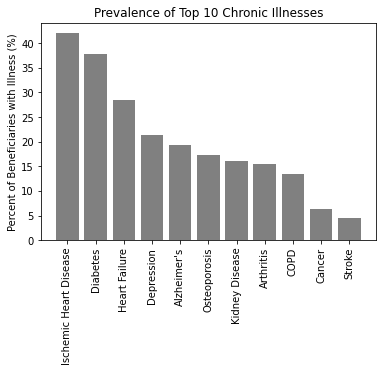

In [438]:
#create bar plot to describe top 10 chronic illness percentages in beneficiaries

diseases = ['Ischemic Heart Disease', 'Diabetes', 
'Heart Failure', 'Depression', "Alzheimer's", 
'Osteoporosis', 'Kidney Disease', 'Arthritis', 
'COPD', 'Cancer', 'Stroke']

prevalence = [
    round(
    (len(bene[bene.SP_ISCHMCHT == 1]) / 
    len(bene)) * 100, 2),

    round(
    (len(bene[bene.SP_DIABETES == 1]) / 
    len(bene)) * 100, 2),

    round(
    (len(bene[bene.SP_CHF == 1]) / 
    len(bene)) * 100, 2),

    round(
    (len(bene[bene.SP_DEPRESSN == 1]) / 
    len(bene)) * 100, 2),

    round(
    (len(bene[bene.SP_ALZHDMTA == 1]) /
    len(bene)) * 100, 2),

    round(
    (len(bene[bene.SP_OSTEOPRS == 1]) / 
    len(bene)) * 100, 2),

    round(
    (len(bene[bene.SP_CHRNKIDN == 1]) / 
    len(bene)) * 100, 2),

    round(
    (len(bene[bene.SP_RA_OA == 1]) / 
    len(bene)) * 100, 2),

    round(
    (len(bene[bene.SP_COPD == 1]) / 
    len(bene)) * 100, 2),

    round(
    (len(bene[bene.SP_CNCR == 1]) / 
    len(bene)) * 100, 2),

    round(
    (len(bene[bene.SP_STRKETIA == 1]) / 
    len(bene)) * 100, 2)
]

plt.bar(diseases, prevalence, color = 'grey')
plt.title('Prevalence of Top 10 Chronic Illnesses')
plt.ylabel("Percent of Beneficiaries with Illness (%)")
plt.xticks(rotation = 90)

Linear Regression Score: 0.006371699044401935
MAE: 2.0030873658347437
MSE: 5.66314620124671
RMSE: 2.379736582323075

Average Age of Beneficiaries with Alzheimer's Disease: 73.91784917447568


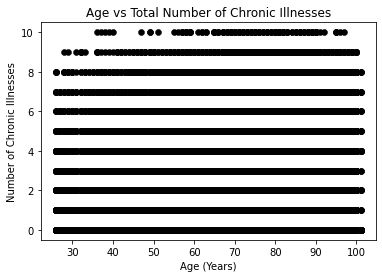

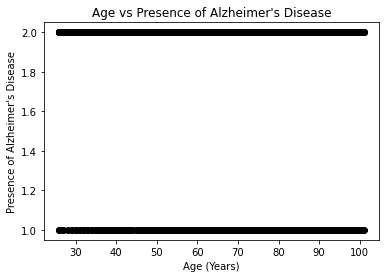

In [439]:
#Investigate whether there is a correlation between age and the number of chronic illnesses per beneficiaries


#plot scatter plot of age vs number of chronic illnesses to observe relationship
fig, ax = plt.subplots()
ax.scatter(bene.AGE_YEARS, bene.TOTAL_CHRONIC_DISEASES, color = 'black', linewidths = 0.5)
plt.title('Age vs Total Number of Chronic Illnesses')
plt.xlabel('Age (Years)')
plt.ylabel('Number of Chronic Illnesses')


#fit linear regression to assess relationship between variables
X = np.array(bene.AGE_YEARS).reshape(-1,1)
y = np.array(bene.TOTAL_CHRONIC_DISEASES).reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

model = LinearRegression().fit(X_train, y_train)

y_pred = model.predict(X_test)

#evaluate model
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) #default=True
rmse = mean_squared_error(y_true=y_test,y_pred=y_pred,squared=False)


print('Linear Regression Score:', model.score(X_test, y_test))
print("MAE:",mae)
print("MSE:",mse)
print("RMSE:",rmse)

#investigate data of alzheimer's disease, 
#find out why there is no relationship between age and illness
fig, ax2 = plt.subplots()
ax2.scatter(bene.AGE_YEARS, bene.SP_ALZHDMTA, color = 'black', linewidths = 0.05)
plt.title("Age vs Presence of Alzheimer's Disease")
plt.xlabel('Age (Years)')
plt.ylabel("Presence of Alzheimer's Disease")

print("\nAverage Age of Beneficiaries with Alzheimer's Disease:", statistics.mean(bene.AGE_YEARS.where(bene.SP_ALZHDMTA == 1).dropna()))

